# Replace star sampling with sampling ranges of L M and T

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform
try:
    plt.style.use('paper')
except:
    pass
from constants import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON, STAR_TYPES

In [2]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [3]:
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [4]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_sampler(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    # Table 1 (KALTENEGGER & TRAUB) https://arxiv.org/ftp/arxiv/papers/0903/0903.3371.pdf
    ML = [7.2/100., 3.5/100., 2.3/100., 1.5/100., 0.55/100., 0.22/100., 0.09/100., 0.05/100., 0.03/100., 0.015/100.]
    MM = [0.60, 0.49, 0.44, 0.36, 0.20, 0.14, 0.10, 0.09, 0.08, 0.075]
    MT = [3800, 3600, 3400, 3250, 3100, 2800, 2600, 2500, 2400, 2300]
    sample = -1
    while sample < 0 or sample > 9:
        sample = int(random.normal(loc=mean, scale=std))
    
    return swarms.Star(M=MM[sample]*MSUN, L=ML[sample]*LSUN, T=MT[sample], d=0) # M star

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 20 # Mearth (just over Nep. Lowest val in Baraffe)
    Mmax = 5*318 # Mearth (5 MJup. Highest in Baraffe)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/PC*IWA# AU
        amax = star.d/PC*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler2():
    y = uniform(0, 1)
    return inverse_cdf(y)*1e6 * YEAR

def age_sampler():
    return loguniform(1.1e7, 1e8) * YEAR

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

# Sample

In [5]:
IWA = 0.2 # arcseconds
OWA = 10
MWA = (IWA + OWA)/2
lamb = 1.65 * MICRON

M0 = 1*MEARTH
aopt = 200 # AU
dopt = aopt/MWA * PC
print('Optimal Distance = {0:.0f} pc'.format(dopt/PC))

Optimal Distance = 39 pc


In [6]:
def sample(M0, dopt, lamb, star_type):
    try:
        star = swarms.Star(STAR_TYPES[star_type]["L"], STAR_TYPES[star_type]["M"], STAR_TYPES[star_type]["T"], d=0)
    except Exception:
        print("failed to find star... randomizing")
        star = star_sampler()
    star.d = dopt#distance_sampler(mean=dopt, std=dopt/2.)
    if star.Imag < 0 or star.Imag > 12:
        #print(star.Imag)
        return sample(M0, dopt, lamb, star_type) # do it again
    age = 25e6 * YEAR # age_sampler()
    
    planet = draw_planet(star, age, IWA=0.2, OWA=10)
    if planet is None:
        return sample(M0, dopt, lamb, star_type) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = uniform(0.2, 0.4) # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0=M0, Dmax=Dmax, Dt=Dt, eta=eta, Q=Q, g=g, rho=rho, 
                             fQ=fQ, Nstr=Nstr, Dmin_min=lamb, age=age)
    CRscatSwarm = swarm.computeCRscat()
    CRscatPlanet = planet.computeCRscat(g)
    CRthermalPlanet = planet.computeCRthermal(lamb)
    #print("Mtot: {0:.2e} \t Tcol: {1:.2e} \t tnleft: {2:.2e} \t Tcol0: {3:.2e} \t 1/(Mplt^0.24 * apl^4.13): {4:.2e}".format(swarm.swarm.M0/MEARTH, swarm.computeTcol()/YEAR, swarm.tnleft/YEAR, swarm.Tcol0, 1./((swarm.planet.M/MEARTH)**0.24 * (swarm.planet.a/AU)**4.13)))
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/PC, planet.M, star.Imag

In [7]:
%%time
seed(0)
M1 = 1*MEARTH
dopt1 = 35 * PC
star_type1 = "M0"
Nsamples = 300
CRscatSwarm1, CRPlanet1, a1, d1, Mplt1, Imag1 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm1[i], CRPlanet1[i], a1[i], d1[i], Mplt1[i], Imag1[i] = sample(M1, dopt1, lamb, star_type1)

CPU times: user 10.8 s, sys: 75.6 ms, total: 10.8 s
Wall time: 10.8 s


In [8]:
%%time
seed(0)
M2 = 0.01*MEARTH
dopt2 = 35 * PC
star_type2 = "M0"
Nsamples = 300
CRscatSwarm2, CRPlanet2, a2, d2, Mplt2, Imag2 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm2[i], CRPlanet2[i], a2[i], d2[i], Mplt2[i], Imag2[i] = sample(M2, dopt2, lamb, star_type2)

CPU times: user 11 s, sys: 87.8 ms, total: 11.1 s
Wall time: 11.1 s


In [9]:
%%time
seed(0)
M4 = 1.e-4*MEARTH
star_type4 = "M0"
dopt4 = 35 * PC
Nsamples = 300
CRscatSwarm4, CRPlanet4, a4, d4, Mplt4, Imag4 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm4[i], CRPlanet4[i], a4[i], d4[i], Mplt4[i], Imag4[i] = sample(M4, dopt4, lamb, star_type4)

CPU times: user 10.3 s, sys: 87.8 ms, total: 10.4 s
Wall time: 10.4 s


In [10]:
%%time
seed(0)
M6 = 1.e-6*MEARTH
dopt6 = 35 * PC
star_type6 = "M0"
Nsamples = 300
CRscatSwarm6, CRPlanet6, a6, d6, Mplt6, Imag6 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm6[i], CRPlanet6[i], a6[i], d6[i], Mplt6[i], Imag6[i] = sample(M6, dopt6, lamb, star_type6)

CPU times: user 10.4 s, sys: 79.9 ms, total: 10.5 s
Wall time: 10.5 s


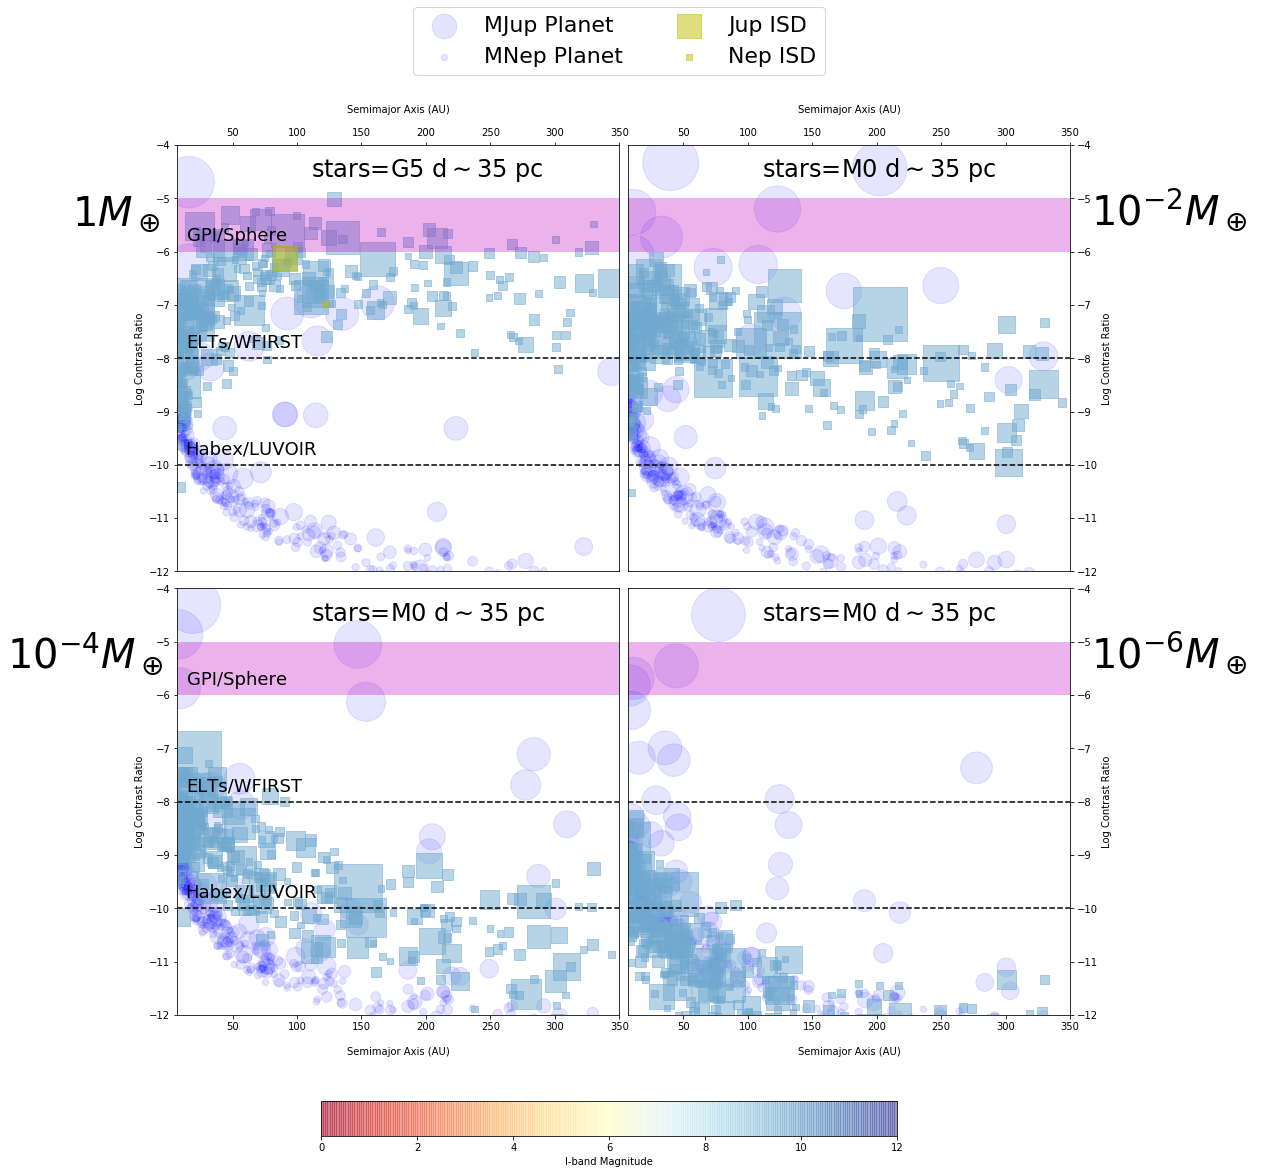

In [13]:
cm = plt.cm.get_cmap('RdYlBu')

def plot(ax, a, logCRscatSwarm, logCRPlanet, Mplt, Imag, dopt):
    Mcut = 2*Mplt/MEARTH
    ax.scatter(a, logCRPlanet, c='b', vmax=12, vmin=0, s=Mcut, alpha=0.1, marker='o')
    sc = ax.scatter(a, logCRscatSwarm, c=Imag, vmax=12, vmin=0, s=Mcut, cmap=cm, alpha=0.5,
                    marker='s')
    ax.axhline(-8, color='k', linestyle='--')
    ax.axhline(-10, color='k', linestyle='--')
    
    ax.set_xlim([IWA*dopt/PC, OWA*dopt/PC])
    ax.set_ylim([-12, -4])
    ax.set_ylabel('Log Contrast Ratio')
    ax.set_xlabel('Semimajor Axis (AU)', labelpad=15)
    mn, mx = ax.get_xlim()
    ax.fill_between(np.linspace(mn, mx, 10), -6, -5, facecolor='m', alpha=0.3)
    return sc

#plt.style.use('paper')
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, figsize=(16,16))
plt.subplots_adjust(wspace=0.02, hspace=0.04)

sc = plot(axs[0,0], a1, np.log10(CRscatSwarm1), np.log10(CRPlanet1), Mplt1, Imag1, dopt1)
sc = plot(axs[0,1], a2, np.log10(CRscatSwarm2), np.log10(CRPlanet2), Mplt2, Imag2, dopt2)
sc = plot(axs[1,0], a4, np.log10(CRscatSwarm4), np.log10(CRPlanet4), Mplt4, Imag4, dopt4)
sc = plot(axs[1,1], a6, np.log10(CRscatSwarm6), np.log10(CRPlanet6), Mplt6, Imag6, dopt6)

#fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)

s=0.9
axs[0,0].text(14.4, -5.8, "GPI/Sphere", color='k', fontsize=18)
axs[0,0].text(13.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axs[0,0].text(13.5, -9.8, "Habex/LUVOIR", color='k', fontsize=18)

axs[1,0].text(14.4, -5.8, "GPI/Sphere", color='k', fontsize=18)
axs[1,0].text(13.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axs[1,0].text(13.5, -9.8, "Habex/LUVOIR", color='k', fontsize=18)

axs[0,0].xaxis.set_label_position("top")
axs[0,0].xaxis.tick_top()
axs[0,1].xaxis.set_label_position("top")
axs[0,1].xaxis.tick_top()

axs[0,1].yaxis.set_label_position("right")
axs[0,1].yaxis.tick_right()
axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()

ax = axs[0,0]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=G5 d$\sim$35 pc", fontsize=24)
ax.text(-0.42*avg, -5.5, r"$1M_\oplus$ ", fontsize=40)
ax = axs[0,1]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$35 pc", fontsize=24)
ax.text(2.05*avg, -5.5, r"$10^{-2}M_\oplus$ ", fontsize=40)
ax = axs[1,0]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$35 pc", fontsize=24)
ax.text(-0.7*avg, -5.5, r"$10^{-4}M_\oplus$ ", fontsize=40)
ax = axs[1,1]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$35 pc", fontsize=24)
ax.text(2.05*avg, -5.5, r"$10^{-6}M_\oplus$ ", fontsize=40)

Mcut1 = 2*Mplt1/MEARTH
Jupmask = np.abs(Mplt1/MEARTH - 318) < 30
Nepmask = np.abs(Mplt1/MEARTH - 20) < 1
sc1 = axs[0,0].scatter(a1[Jupmask][0], np.log10(CRPlanet1)[Jupmask][0], c='b', vmax=12, vmin=0, s=Mcut1[Jupmask][0], alpha=0.1, marker='o', label="MJup Planet")
sc2 = axs[0,0].scatter(a1[Nepmask][0], np.log10(CRPlanet1)[Nepmask][0], c='b', vmax=12, vmin=0, s=Mcut1[Nepmask][0], alpha=0.1, marker='o', label="MNep Planet")
sc3 = axs[0,0].scatter(a1[Jupmask][0], np.log10(CRscatSwarm1)[Jupmask][0], c='y', vmax=12, vmin=0, s=Mcut1[Jupmask][0], alpha=0.5, marker='s', label="Jup ISD")
sc4 = axs[0,0].scatter(a1[Nepmask][0], np.log10(CRscatSwarm1)[Nepmask][0], c='y', vmax=12, vmin=0, s=Mcut1[Nepmask][0], alpha=0.5, marker='s', label="Nep ISD")

#axs[0,0].set_title("TWA", loc='left', pad=80, fontsize=22)
axs[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=2, fontsize=22)

cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
cbar = fig.colorbar(sc, cax=cb_ax, orientation='horizontal', label='I-band Magnitude')

#plt.colorbar(sc, orientation='horizontal')